<a href="https://colab.research.google.com/github/setthawut8/ai/blob/main/%5BBinary%20Text%20Classification%5D%20downsampling_bert" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspiration: https://youtu.be/hOCDJyZ6quA

#Library and Installation

In [ ]:
!pip install fairseq
!pip install pythainlp
!pip install sacremoses
!pip install transformers
!pip install sentencepiece
!pip install tensorflow-text
!gdown --id xx!gdown --id xx

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from pythainlp.translate import Translate


from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train = pd.read_excel('/content/SET_Filtering_preprocessed_train_sampling1898_20220622.xlsx', engine='openpyxl')
test = pd.read_excel('/content/SET_Filtering_preprocessed_test_sampling335_20220622.xlsx', engine='openpyxl')

In [3]:
train.head(2)

,verbatim_id,verbatim,Filtering,Text_ws_local
0,524121789376412_397916622205355,กำไร bitkub ดีต่อหุ้นของ bitkub ไม่ใช่เหรียญ k...,Relevant,กำไร| |bitkub| |ดี|ต่อ|หุ้น|ของ| |bitkub| |ไม่...
1,1520537844074577921,HUG available at @foundation! Reserve price 0...,Relevant,hug| |available| |at| |friendtag| |reserve| |p...


#EDA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898 entries, 0 to 1897
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   verbatim_id    1898 non-null   object
 1   verbatim       1898 non-null   object
 2   Filtering      1898 non-null   object
 3   Text_ws_local  1898 non-null   object
dtypes: object(4)
memory usage: 59.4+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   verbatim_id    335 non-null    object
 1   verbatim       335 non-null    object
 2   Filtering      335 non-null    object
 3   Text_ws_local  335 non-null    object
dtypes: object(4)
memory usage: 10.6+ KB


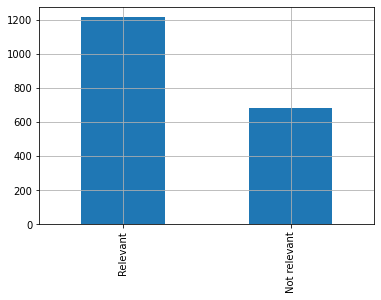

In [15]:
train['Filtering'].value_counts().sort_values(ascending=False).plot(kind='bar',grid=True)

##Downsampling

In [12]:
df_relevant = train[train['Filtering']=='Relevant'] 
df_irrelevant = train[train['Filtering']=='Not relevant']

In [14]:
print(train['Filtering'].value_counts())
print(df_relevant.shape, df_irrelevant.shape)
df_relevant_downsampled = df_relevant.sample(df_irrelevant.shape[0])
print(df_relevant_downsampled.shape)

Relevant        1215
Not relevant     683
Name: Filtering, dtype: int64
(1215, 4) (683, 4)


In [24]:
df_balanced = pd.concat([df_irrelevant, df_relevant_downsampled])
print(df_balanced['Filtering'].value_counts())
df_balanced['relevant'] = df_balanced['Filtering'].apply(lambda x: 1 if x =='Relevant' else 0)
df_balanced.sample(10)

Not relevant    683
Relevant        683
Name: Filtering, dtype: int64


,verbatim_id,verbatim,Filtering,Text_ws_local,relevant
1343,4ff6dfc17352edc30b6d9cb97c375000_,อุตสาหกรรมประสานเสียงตอบรับเห็นด้วย มีเพียงเอไ...,Not relevant,อุตสาหกรรม|ประสานเสียง|ตอบรับ|เห็นด้วย| |มี|เพ...,0
517,1521726711456759809,ไม่อยากได้nft อยากได้ 10fight10 BNK48 55555555...,Not relevant,ไม่|อยากได้| |nft| |อยากได้| |10|fight|10| |bn...,0
89,287839984997170_1435667773547713,ในโอกาสที่เราจะเปิดใช้งานระบบ ก็ต้องแจก NFT กั...,Relevant,ใน|โอกาส|ที่|เรา|จะ|เปิด|ใช้งาน|ระบบ| |ก็|ต้อง...,1
995,128368057282830_4956857507767170,#เปิดรับสมัครแล้ว ========================== #...,Not relevant,เปิด|รับสมัคร|แล้ว| |คอร์ส| |online| |รุ่น| |6...,0
1158,567755971375910_3143197902596379,Bitkub ต่างจาก binance ตรงไหนบ้างครับ,Relevant,bitkub| |ต่าง|จาก| |binance| |ตรงไหน|บ้าง|ครับ,1
943,10160503654928291_410947210869406,อันนี้ประกาศจากทาง Bitkub หัวข้อ กรณีคณะกรรม...,Relevant,อันนี้|ประกาศ|จาก|ทาง| |bitkub| |หัวข้อ| |กรณี...,1
273,1521169152194805760,#เหรินเจียหลุน​ [นักลงทุนผู้เปล่งประกาย​ ตอนที...,Not relevant,เห|ริน|เจียห|ลุ|น| |นักลงทุน|ผู้|เปล่งประกาย| ...,0
467,d6fb59489421bf8c14061a334dfa9e23_,ดัชนีและภาวะตลาดหุ้น น้ำมัน ทองคำ และตลาดเงินต...,Relevant,ดัชนี|และ|ภาวะ|ตลาดหุ้น| |น้ำมัน| |ทองคำ| |และ...,1
1676,261923537346273_2056811684524107,กองทุน K-VIETNAM-RMF ✅เป็นอีกทางเลือกสำหรับผู้...,Relevant,กองทุน| |k-vietnam-rmf| |เป็น|อีก|ทางเลือก|สำห...,1
289,2960813594_CdBQc6toZkT_18016630801385562,"Do you know that you can start earning $25,000...",Relevant,do| |you| |know| |that| |you| |can| |start| |e...,1


In [72]:
###Aimming to translate thai to eng first
# th2en = Translate('th','en')
# th2en.translate(df_balanced['verbatim'].loc[517])

In [ ]:
df_balanced['verbatim_en'] = 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['verbatim'], df_balanced['relevant'], stratify=df_balanced['relevant'])

#Model

In [50]:
txt1 = df_balanced['verbatim'].loc[1343]
txt2 = df_balanced['verbatim'].loc[517]
get_sentence_embedding([txt1,txt2])

In [51]:
e = get_sentence_embedding([
                            "กล้วย",
                            "องุ่น",
                            "มะม่วง",
                            "เจฟ เบซอส",
                            "อีรอน มัคส์",
                            "บิล เกตต์",
])
cosine_similarity([e[0]],[e[2]])

In [29]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [48]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

In [81]:
#Bert Layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Neural Network Layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid',name='output')(l)

#construcut a final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [82]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [83]:
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS
              )

In [84]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
32/32 [==============================] - 20s 258ms/step - loss: 0.6996 - accuracy: 0.5557 - precision: 0.5529 - recall: 0.5820
Epoch 2/10
32/32 [==============================] - 8s 238ms/step - loss: 0.7105 - accuracy: 0.5312 - precision: 0.5335 - recall: 0.4980
Epoch 3/10
32/32 [==============================] - 8s 254ms/step - loss: 0.6704 - accuracy: 0.5791 - precision: 0.5692 - recall: 0.6504
Epoch 4/10
32/32 [==============================] - 9s 264ms/step - loss: 0.6758 - accuracy: 0.5781 - precision: 0.5766 - recall: 0.5879
Epoch 5/10
32/32 [==============================] - 8s 250ms/step - loss: 0.6631 - accuracy: 0.6045 - precision: 0.6103 - recall: 0.5781
Epoch 6/10
32/32 [==============================] - 8s 251ms/step - loss: 0.6538 - accuracy: 0.6338 - precision: 0.6179 - recall: 0.7012
Epoch 7/10
32/32 [==============================] - 8s 248ms/step - loss: 0.6429 - accuracy: 0.6562 - precision: 0.6527 - recall: 0.6680
Epoch 8/10
32/32 [======================

In [85]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 4s 242ms/step - loss: 0.6412 - accuracy: 0.6374 - precision: 0.6516 - recall: 0.5906


[0.6412084698677063,
 0.6374269127845764,
 0.6516128778457642,
 0.5906432867050171]

In [89]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

11/11 [==============================] - 3s 243ms/step


In [94]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,

In [98]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[117,  54],
       [ 70, 101]])

Text(33.0, 0.5, 'Actual')

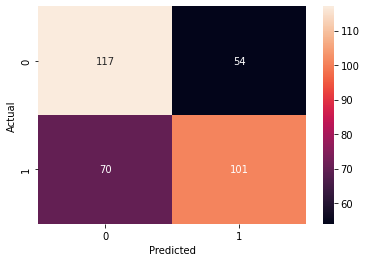

In [99]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [100]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65       171
           1       0.65      0.59      0.62       171

    accuracy                           0.64       342
   macro avg       0.64      0.64      0.64       342
weighted avg       0.64      0.64      0.64       342

